In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import glob
import tensorflow.keras.datasets.mnist as mnist

In [2]:
imgs_path = glob.glob(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\cityscapes-image-pairs\train\*.jpg')
print(imgs_path[0:3],len(imgs_path))
imgs_path_test = glob.glob(r'F:\course_video\WY0x000172 GAN生成对抗网络入门与实战\代码和数据集\2.0部分数据集\cityscapes-image-pairs\val\*.jpg')
print(len(imgs_path_test))

['F:\\course_video\\WY0x000172 GAN生成对抗网络入门与实战\\代码和数据集\\2.0部分数据集\\cityscapes-image-pairs\\train\\1.jpg', 'F:\\course_video\\WY0x000172 GAN生成对抗网络入门与实战\\代码和数据集\\2.0部分数据集\\cityscapes-image-pairs\\train\\10.jpg', 'F:\\course_video\\WY0x000172 GAN生成对抗网络入门与实战\\代码和数据集\\2.0部分数据集\\cityscapes-image-pairs\\train\\100.jpg'] 2975
500


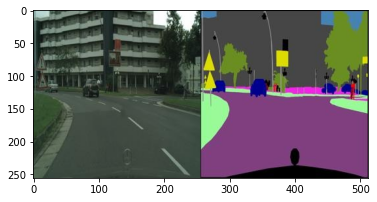

In [3]:
plt.imshow(tf.keras.preprocessing.image.load_img(imgs_path[0]))

In [4]:
def read_jpg(path):
    '''
    读取存放图片的路径，并将该路径转换为图片数据
    '''
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    return img

def normalize(input_image,input_mask):
    '''
    对图片进行归一化到-1到1
    iamge为左半图片
    mask为右半图片
    '''
    input_image=tf.cast(input_image,tf.float32)/127.5-1
    input_mask=tf.cast(input_mask,tf.float32)/127.5-1
    return input_image,input_mask

def load_image(image_path):
    '''
    将完整的图片进行分割(同时做了数据增广，归一化)
    '''
    
    # 数字化图片
    image=read_jpg(image_path) # shape(w,h,c)
    
    # 对图片进行对半分割
    w=tf.shape(image)[1]
    w=w//2
    input_image=image[:,:w,:]
    input_mask=image[:,w:,:]
    
    # resize
    input_image=tf.image.resize(input_image,(64,64))  # (64,64,3)
    input_mask=tf.image.resize(input_mask,(64,64))

    # 数据增广
    if tf.random.uniform(()) > 0.5:  # 生成一个在[0,1)之间的数据
        input_image=tf.image.flip_left_right(input_image) # 翻转图片
        input_mask=tf.image.flip_left_right(input_mask)
    
    # 数据归一化
    input_image,input_mask=normalize(input_image,input_mask)
    return input_image,input_mask



def load_image_test(image_path):
    '''
    将完整的test图片进行分割(同时做了数据增广，归一化)
    '''
    
    # 数字化图片
    image=read_jpg(image_path) # shape(w,h,c)
    
    # 对图片进行对半分割
    w=tf.shape(image)[1]
    w=w//2
    input_image=image[:,:w,:]
    input_mask=image[:,w:,:]
    
    # resize
    input_image=tf.image.resize(input_image,(64,64))  # (64,64,3)
    input_mask=tf.image.resize(input_mask,(64,64))

    # 数据归一化
    input_image,input_mask=normalize(input_image,input_mask)
    return input_image,input_mask

In [5]:
# 建立数据集
train_dataset=tf.data.Dataset.from_tensor_slices(imgs_path)
test_dataset=tf.data.Dataset.from_tensor_slices(imgs_path_test)

train_dataset=train_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.map(load_image_test)

BATCH_SIZE = 64
BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE)

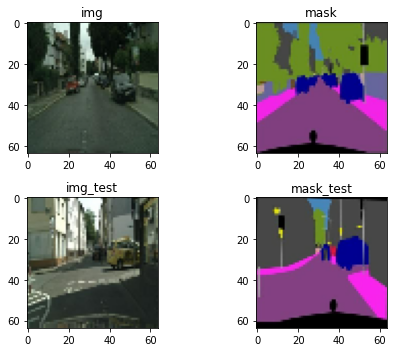

In [6]:
# 查看一个处理好的train和test图片
plt.figure(figsize=(7,5))
for (img,mask),(img_test,mask_test) in zip(train_dataset.take(1),test_dataset.take(1)):
    plt.subplot(2,2,1)
    plt.title('img')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(2,2,2)
    plt.title('mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    
    plt.subplot(2,2,3)
    plt.title('img_test')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_test[0]))
    plt.subplot(2,2,4)
    plt.title('mask_test')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_test[0]))
    plt.tight_layout()

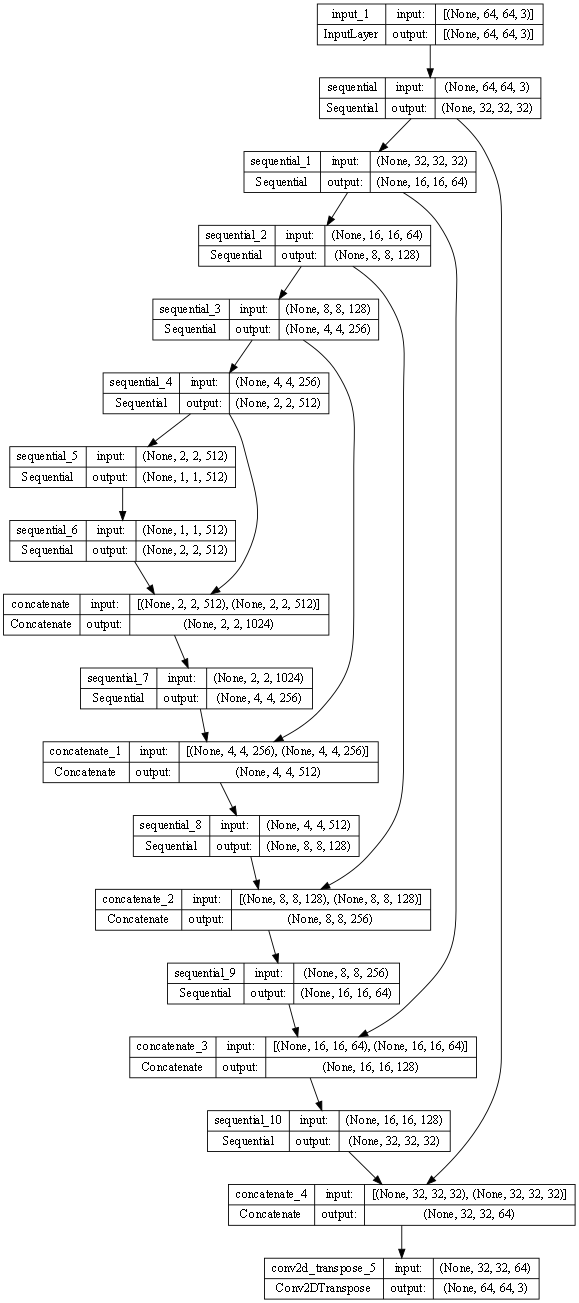

In [7]:
def downsample(filters,size,apply_batchnorm=True):
    '''
    filters: 输出通道数
    size: 卷积核尺寸
    '''
    result=tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',
                              use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
        result.add(tf.keras.layers.LeakyReLU())
    return result


def upsample(filters,size,apply_dropout=False):
    result=tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',
                              use_bias=False))
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
        result.add(tf.keras.layers.ReLU())
    return result


def generator():
    inputs=tf.keras.layers.Input(shape=[64,64,3])
    OUTPUT_CHANNELS = 3
    
    down_stack=[
        downsample(32,3,apply_batchnorm=False),
        downsample(64,3),
        downsample(128,3),
        downsample(256,3),
        downsample(512,3),
        downsample(512,3)  # （batchsize,1,1,512）
    ]
    
    up_stack=[
            upsample(512,3,apply_dropout=True),
            upsample(256,3,apply_dropout=True),
            upsample(128,3,apply_dropout=True),
            upsample(64,3),
            upsample(32,3) # （batchsize,32,32,32）
    ]
    
    last=tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,3,
                                        strides=2,
                                        padding='same',
                                        activation='tanh') # （batchsize,64,64,3）
    x=inputs
    skips=[]
    
    # 依次进行下采样
    for down in down_stack:
        x=down(x)
        skips.append(x) # 将每次下采样的值记录
    
    skips=reversed(skips[:-1]) # 先取出前n-1个值，再将他们反序排列
    
    # 依次进行上采样，并进行残差连接
    
    for up,skip in zip(up_stack,skips):
        x=up(x)
        x=tf.keras.layers.Concatenate()([x,skip])
    
    x=last(x) # 最后再经过一层卷积
    
    return tf.keras.Model(inputs=inputs,outputs=x)


def discriminator():
    inp=tf.keras.layers.Input(shape=[64,64,3],name='input_image')
    tar=tf.keras.layers.Input(shape=[64,64,3],name='tar_image')
    
    x=tf.keras.layers.concatenate([inp,tar]) #  （batchsize,64,64,channels*2）
    
    down1=downsample(32,3,False)(x)
    down2=downsample(64,3,False)(down1)
    down3=downsample(128,3,False)(down2)
    
    conv=tf.keras.layers.Conv2D(256,3,strides=1,padding='same',use_bias=False)(down3)
    
    batchnorm1=tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu=tf.keras.layers.LeakyReLU()(batchnorm1)
    
    last=tf.keras.layers.Conv2D(1,3,strides=1)(leaky_relu)
    
    return tf.keras.Model(inputs=[inp,tar],outputs=last)


generator=generator()
discriminator=discriminator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [19]:
LAMBDA = 10
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_gneerated_output,gen_output,target):
    gan_Loss=loss_object(tf.ones_like(disc_gneerated_output),
                         disc_gneerated_output)
    L1_loss=tf.reduce_mean(tf.abs(target-gen_output))
    return gan_Loss+(LAMBDA*L1_loss),gan_Loss,L1_loss

def discriminator_loss(disc_real_output,disc_gneerated_output):
    real_loss=loss_object(tf.ones_like(disc_real_output),disc_real_output)
    
    generated_loss=loss_object(tf.zeros_like(disc_gneerated_output),disc_gneerated_output)
    
    return real_loss+generated_loss

# 优化器
generator_opti=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_opti=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [9]:
tf.config.run_functions_eagerly(True)

@tf.function  # 函数修饰器,将用户定义的python风格的函数代码转化成高效的tensorflow计算图
                # 可以加速网络的推理速度,还能够有效降低占用显卡显存,使低显存的显卡也可以跑大网络
def train_step(input_images,target):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_image=generator(input_images,training=True)    # 输入真实图像去生成语义分割图像
        
        # 输出结果向量
        disc_real_output=discriminator([input_images,target],training=True) # 输入真实图像和语义分割图像
        disc_generated_output=discriminator([input_images,gen_image],training=True) # 输入生成图像和真实图像
        
        # 输出计算的loss 
        gen_total_loss,gen_gan_loss,gen_L1_loss=generator_loss(
                                disc_generated_output,gen_image,target)
        disc_loss=discriminator_loss(disc_real_output,disc_generated_output)
        
    gradient_gen=gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    gradient_disc=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_opti.apply_gradients(zip(gradient_gen,generator.trainable_variables))
    discriminator_opti.apply_gradients(zip(gradient_disc,discriminator.trainable_variables))
    return gen_total_loss,disc_loss

In [10]:
def generator_plot_image(gen_model,test_input,tar):  # 
    pred_images=gen_model(test_input,training=False) # 查看利用噪声数据生成出16的图像

    fig=plt.figure(figsize=(10,5))
    display_List=[test_input[0],tar[0],pred_images[0]]
    title=['input_image','ground truth','predicted image']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_List[i]*0.5+0.5) # 画出利用噪声数据gen出的图像
        plt.axis('off')
    plt.show()

In [14]:
epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')
g_loss_results = []
d_loss_results = []

def train(dataset,epochs,test_dataset):
    for epoch in range(epochs):
        for input_image,target in dataset:
            g_loss, d_loss = train_step(input_image,target)
            # 计算每个epoch的平均loss
            epoch_loss_avg_gen(g_loss)
            epoch_loss_avg_disc(d_loss)
            print('.',end='')
        # 记录每个epoch的loss
        g_loss_results.append(epoch_loss_avg_gen.result())
        d_loss_results.append(epoch_loss_avg_disc.result())
        
        epoch_loss_avg_gen.reset_states() # 将loss的buffer清除掉
        epoch_loss_avg_disc.reset_states()
        
        # 判断利用test数据进行GAN画图
        if epoch%5==0:
            # 画noise生成的图
            for example_input,example_target in test_dataset.take(1):
                generator_plot_image(generator,example_input,example_target)
        print('将开始第{}轮epoch'.format(epoch+1))
    
    # 将最后一次epoch的图画出
    for example_input,example_target in test_dataset.take(1):
        generator_plot_image(generator,example_input,example_target)

...............................................

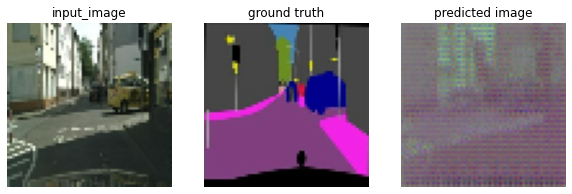

将开始第1轮epoch
...............................................将开始第2轮epoch
...............................................将开始第3轮epoch
...............................................将开始第4轮epoch
...............................................将开始第5轮epoch
...............................................

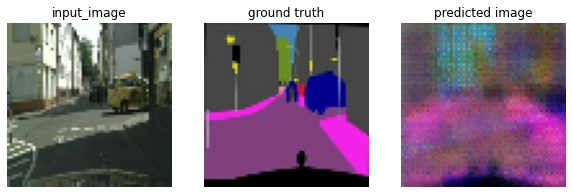

将开始第6轮epoch
...............................................将开始第7轮epoch
...............................................将开始第8轮epoch
...............................................将开始第9轮epoch
...............................................将开始第10轮epoch
...............................................

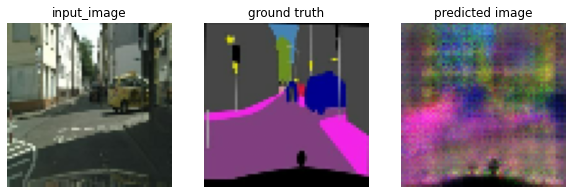

将开始第11轮epoch
...............................................将开始第12轮epoch
...............................................将开始第13轮epoch
...............................................将开始第14轮epoch
...............................................将开始第15轮epoch
...............................................

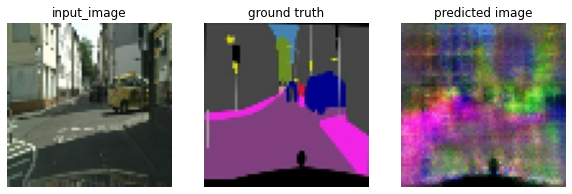

将开始第16轮epoch
...............................................将开始第17轮epoch
...............................................将开始第18轮epoch
...............................................将开始第19轮epoch
...............................................将开始第20轮epoch
...............................................

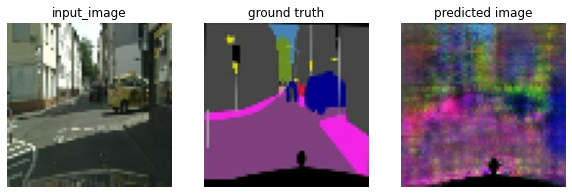

将开始第21轮epoch
...............................................将开始第22轮epoch
...............................................将开始第23轮epoch
...............................................将开始第24轮epoch
...............................................将开始第25轮epoch
...............................................

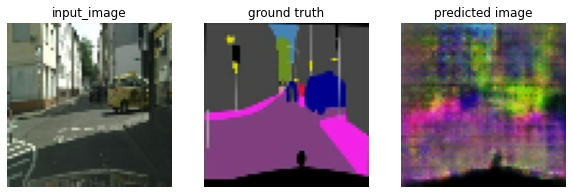

将开始第26轮epoch
...............................................将开始第27轮epoch
...............................................将开始第28轮epoch
...............................................将开始第29轮epoch
...............................................将开始第30轮epoch
...............................................

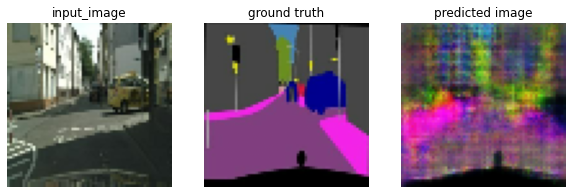

将开始第31轮epoch
...............................................将开始第32轮epoch
...............................................将开始第33轮epoch
...............................................将开始第34轮epoch
...............................................将开始第35轮epoch
...............................................

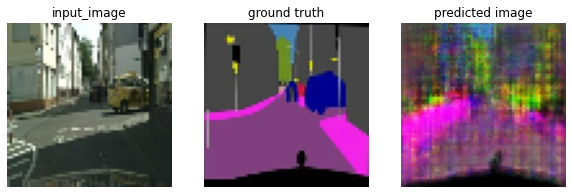

将开始第36轮epoch
...............................................将开始第37轮epoch
...............................................将开始第38轮epoch
...............................................将开始第39轮epoch
...............................................将开始第40轮epoch
...............................................

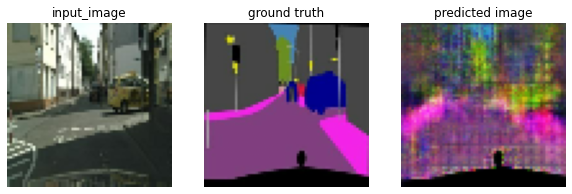

将开始第41轮epoch
...............................................将开始第42轮epoch
...............................................将开始第43轮epoch
...............................................将开始第44轮epoch
...............................................将开始第45轮epoch
...............................................

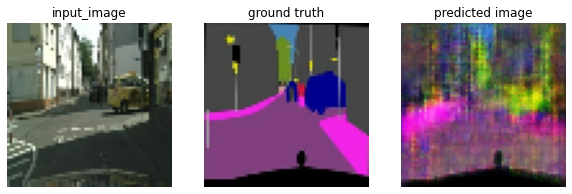

将开始第46轮epoch
...............................................将开始第47轮epoch
...............................................将开始第48轮epoch
...............................................将开始第49轮epoch
...............................................将开始第50轮epoch
...............................................

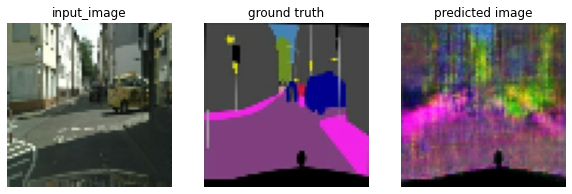

将开始第51轮epoch
...............................................将开始第52轮epoch
...............................................将开始第53轮epoch
...............................................将开始第54轮epoch
...............................................将开始第55轮epoch
...............................................

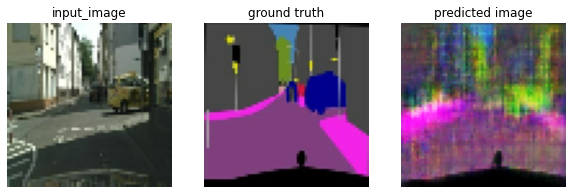

将开始第56轮epoch
...............................................将开始第57轮epoch
...............................................将开始第58轮epoch
...............................................将开始第59轮epoch
...............................................将开始第60轮epoch
...............................................

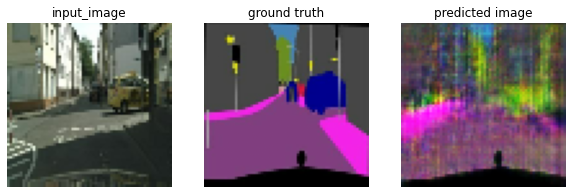

将开始第61轮epoch
...............................................将开始第62轮epoch
...............................................将开始第63轮epoch
...............................................将开始第64轮epoch
...............................................将开始第65轮epoch
...............................................

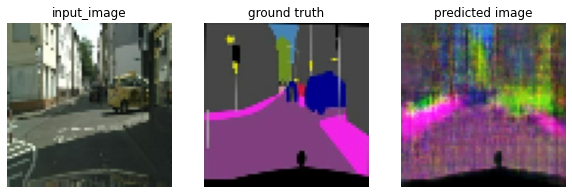

将开始第66轮epoch
...............................................将开始第67轮epoch
...............................................将开始第68轮epoch
...............................................将开始第69轮epoch
...............................................将开始第70轮epoch
...............................................

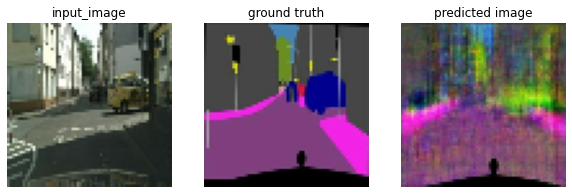

将开始第71轮epoch
...............................................将开始第72轮epoch
...............................................将开始第73轮epoch
...............................................将开始第74轮epoch
...............................................将开始第75轮epoch
...............................................

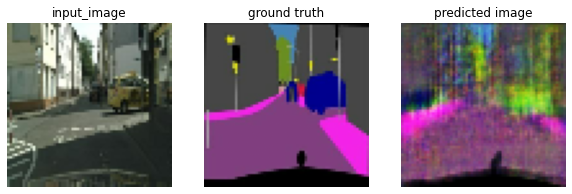

将开始第76轮epoch
...............................................将开始第77轮epoch
...............................................将开始第78轮epoch
...............................................将开始第79轮epoch
...............................................将开始第80轮epoch
...............................................

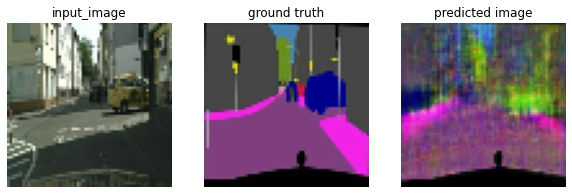

将开始第81轮epoch
...............................................将开始第82轮epoch
...............................................将开始第83轮epoch
...............................................将开始第84轮epoch
...............................................将开始第85轮epoch
...............................................

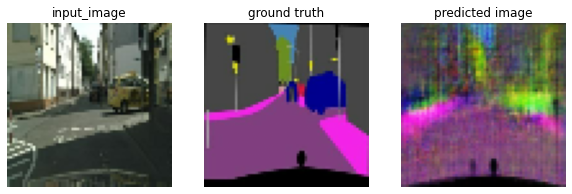

将开始第86轮epoch
...............................................将开始第87轮epoch
...............................................将开始第88轮epoch
...............................................将开始第89轮epoch
...............................................将开始第90轮epoch
...............................................

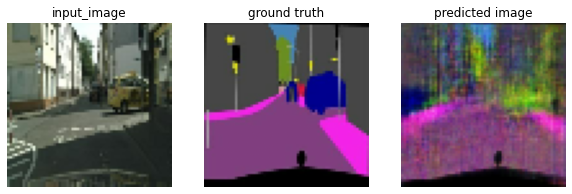

将开始第91轮epoch
...............................................将开始第92轮epoch
...............................................将开始第93轮epoch
...............................................将开始第94轮epoch
...............................................将开始第95轮epoch
...............................................

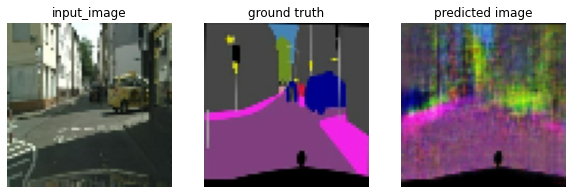

将开始第96轮epoch
...............................................将开始第97轮epoch
...............................................将开始第98轮epoch
...............................................将开始第99轮epoch
...............................................将开始第100轮epoch


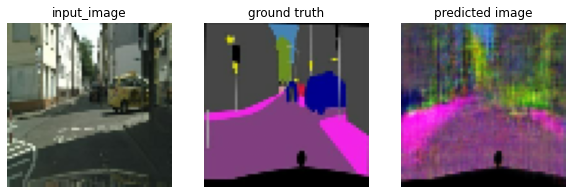

In [16]:
epochs=100
train(train_dataset,epochs,test_dataset)

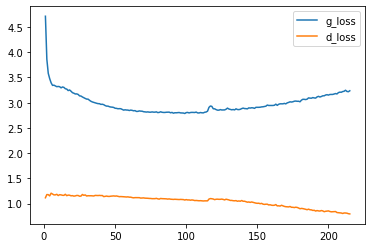

[1.1137382  1.1772604  1.1756992  1.1512055  1.2044915  1.1866347
 1.1710677  1.1715313  1.1824347  1.1579977  1.174933   1.1712834
 1.1634175  1.1617877  1.1832365  1.1557604  1.1666371  1.1648852
 1.1525979  1.1563576  1.146688   1.1506784  1.1598008  1.159175
 1.1446748  1.1473999  1.1791681  1.1626123  1.1704756  1.1486905
 1.1546857  1.1530739  1.1543204  1.1522948  1.1494437  1.160808
 1.1583886  1.1578254  1.1608771  1.1575425  1.1589826  1.1369287
 1.1431172  1.1476111  1.1412977  1.1405898  1.1454322  1.1479838
 1.150679   1.1464553  1.1495934  1.143442   1.1357393  1.1378403
 1.1369789  1.1340114  1.1321915  1.1290959  1.1318982  1.1257756
 1.1258862  1.1175246  1.1129104  1.1166924  1.1165462  1.1164006
 1.1161088  1.1073459  1.1099706  1.1115022  1.1064396  1.1058213
 1.1037033  1.1007404  1.1001523  1.096166   1.0956092  1.0964357
 1.1021702  1.0929114  1.0870123  1.0999981  1.0964705  1.0954863
 1.0930717  1.0926298  1.0875208  1.0916004  1.0858624  1.0833519
 1.0814126  

In [23]:
plt.plot(range(1, len(g_loss_results)+1), g_loss_results, label='g_loss')
plt.plot(range(1, len(d_loss_results)+1), d_loss_results, label='d_loss')
plt.legend()
plt.show()
print(np.array(d_loss_results))

In [21]:
generator.save('gen_model/pix2pix.h5')

...............................................

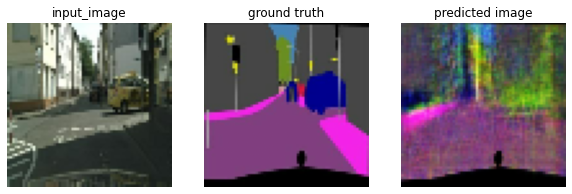

将开始第1轮epoch
...............................................将开始第2轮epoch
...............................................将开始第3轮epoch
...............................................将开始第4轮epoch
...............................................将开始第5轮epoch
...............................................

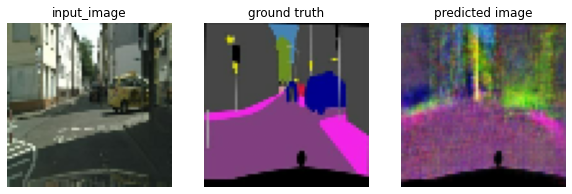

将开始第6轮epoch
...............................................将开始第7轮epoch
...............................................将开始第8轮epoch
...............................................将开始第9轮epoch
...............................................将开始第10轮epoch
...............................................

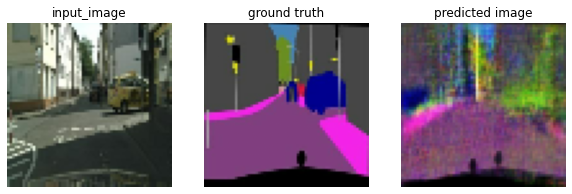

将开始第11轮epoch
...............................................将开始第12轮epoch
...............................................将开始第13轮epoch
...............................................将开始第14轮epoch
...............................................将开始第15轮epoch
...............................................

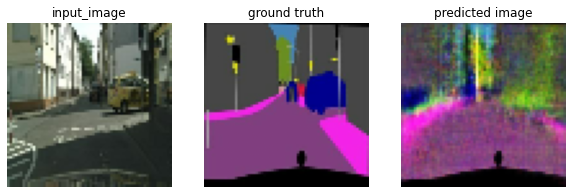

将开始第16轮epoch
...............................................将开始第17轮epoch
...............................................将开始第18轮epoch
...............................................将开始第19轮epoch
...............................................将开始第20轮epoch
...............................................

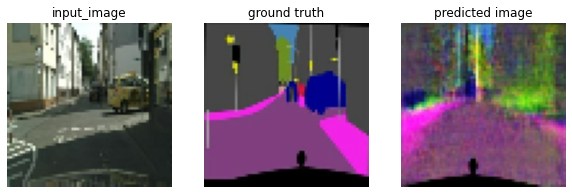

将开始第21轮epoch
...............................................将开始第22轮epoch
...............................................将开始第23轮epoch
...............................................将开始第24轮epoch
...............................................将开始第25轮epoch
...............................................

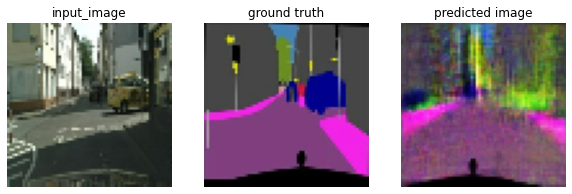

将开始第26轮epoch
...............................................将开始第27轮epoch
...............................................将开始第28轮epoch
...............................................将开始第29轮epoch
...............................................将开始第30轮epoch
...............................................

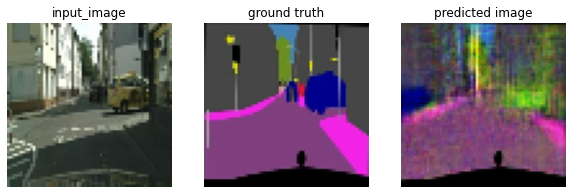

将开始第31轮epoch
...............................................将开始第32轮epoch
...............................................将开始第33轮epoch
...............................................将开始第34轮epoch
...............................................将开始第35轮epoch
...............................................

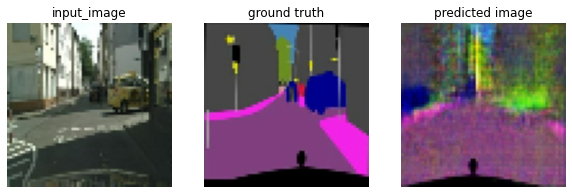

将开始第36轮epoch
...............................................将开始第37轮epoch
...............................................将开始第38轮epoch
...............................................将开始第39轮epoch
...............................................将开始第40轮epoch
...............................................

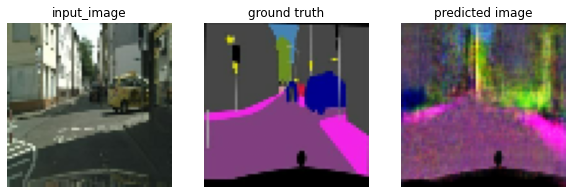

将开始第41轮epoch
...............................................将开始第42轮epoch
...............................................将开始第43轮epoch
...............................................将开始第44轮epoch
...............................................将开始第45轮epoch
...............................................

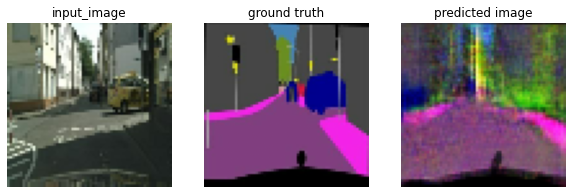

将开始第46轮epoch
...............................................将开始第47轮epoch
...............................................将开始第48轮epoch
...............................................将开始第49轮epoch
...............................................将开始第50轮epoch
...............................................

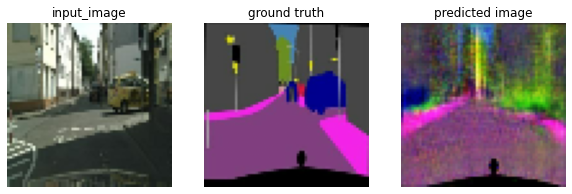

将开始第51轮epoch
...............................................将开始第52轮epoch
...............................................将开始第53轮epoch
...............................................将开始第54轮epoch
...............................................将开始第55轮epoch
...............................................

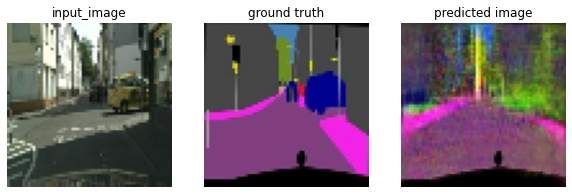

将开始第56轮epoch
...............................................将开始第57轮epoch
...............................................将开始第58轮epoch
...............................................将开始第59轮epoch
...............................................将开始第60轮epoch
...............................................

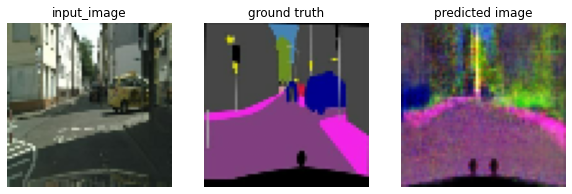

将开始第61轮epoch
...............................................将开始第62轮epoch
...............................................将开始第63轮epoch
...............................................将开始第64轮epoch
...............................................将开始第65轮epoch
...............................................

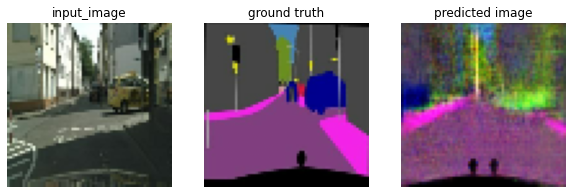

将开始第66轮epoch
...............................................将开始第67轮epoch
...............................................将开始第68轮epoch
...............................................将开始第69轮epoch
...............................................将开始第70轮epoch
...............................................

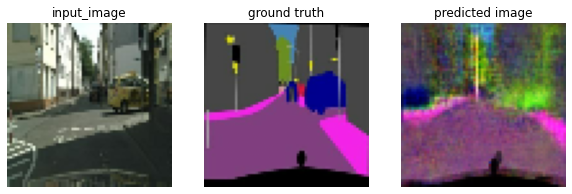

将开始第71轮epoch
...............................................将开始第72轮epoch
...............................................将开始第73轮epoch
...............................................将开始第74轮epoch
...............................................将开始第75轮epoch
...............................................

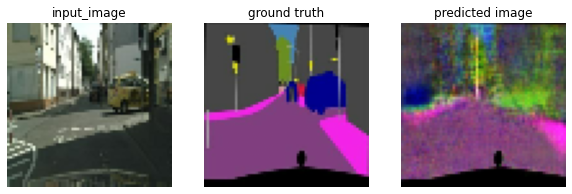

将开始第76轮epoch
...............................................将开始第77轮epoch
...............................................将开始第78轮epoch
...............................................将开始第79轮epoch
...............................................将开始第80轮epoch
...............................................

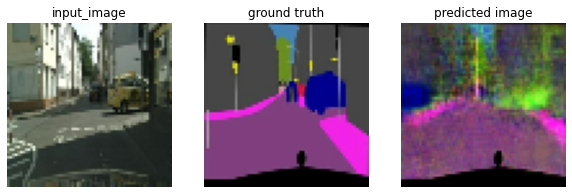

将开始第81轮epoch
...............................................将开始第82轮epoch
...............................................将开始第83轮epoch
...............................................将开始第84轮epoch
...............................................将开始第85轮epoch
...............................................

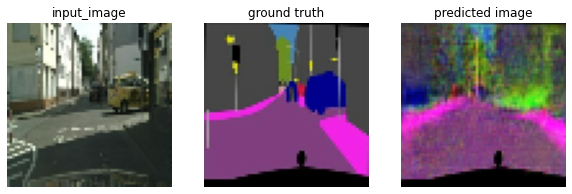

将开始第86轮epoch
...............................................将开始第87轮epoch
...............................................将开始第88轮epoch
...............................................将开始第89轮epoch
...............................................将开始第90轮epoch
...............................................

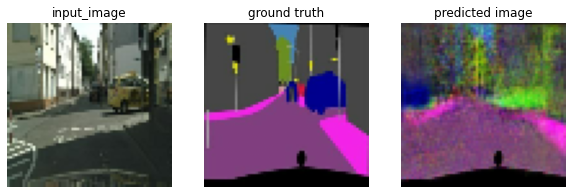

将开始第91轮epoch
...............................................将开始第92轮epoch
...............................................将开始第93轮epoch
...............................................将开始第94轮epoch
...............................................将开始第95轮epoch
...............................................

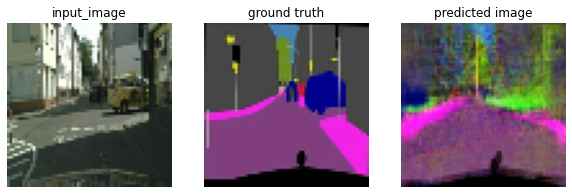

将开始第96轮epoch
...............................................将开始第97轮epoch
...............................................将开始第98轮epoch
...............................................将开始第99轮epoch
...............................................将开始第100轮epoch


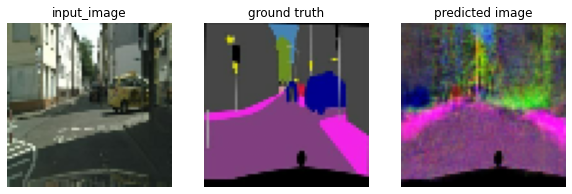

In [20]:
epochs=100
train(train_dataset,epochs,test_dataset)